# Missing Data Analysis

In [1]:
import missingno as msno

import seaborn as sns
sns.set_style("whitegrid")
from common_functions import * 

In [2]:
%store -r COI2 COI MICROSTATES NON_CONFLICT_COUNTRIES CONFLICT_COUNTRIES LOW_CONFLICT_COUNTRIES HIGH_CONFLICT_COUNTRIES acled_by_country

### SE Overview

In [3]:
se_monthly = pd.read_csv("../data/TB014_SOCIO_ECONOMIC_INDICATORS_RAW_MONTHLY.csv")
se_monthly = se_monthly.set_index(pd.DatetimeIndex(se_monthly.DATE))
se_monthly = se_monthly.drop("DATE", axis=1)
print(se_monthly.shape)
se_monthly= se_monthly.dropna(axis=1, how='all')
print(se_monthly.shape)
se_monthly

(565, 11690)
(565, 11690)


,IMF_BCA_NGDPD_ABW,IMF_BCA_NGDPD_AFG,IMF_BCA_NGDPD_AGO,IMF_BCA_NGDPD_ALB,IMF_BCA_NGDPD_AND,IMF_BCA_NGDPD_ARE,IMF_BCA_NGDPD_ARG,IMF_BCA_NGDPD_ARM,IMF_BCA_NGDPD_ATG,IMF_BCA_NGDPD_AUS,...,WB_VOICE_ACCOUNTABILITY_ESTIMATE_VEN,WB_VOICE_ACCOUNTABILITY_ESTIMATE_VIR,WB_VOICE_ACCOUNTABILITY_ESTIMATE_VNM,WB_VOICE_ACCOUNTABILITY_ESTIMATE_VUT,WB_VOICE_ACCOUNTABILITY_ESTIMATE_WSM,WB_VOICE_ACCOUNTABILITY_ESTIMATE_XKX,WB_VOICE_ACCOUNTABILITY_ESTIMATE_YEM,WB_VOICE_ACCOUNTABILITY_ESTIMATE_ZAF,WB_VOICE_ACCOUNTABILITY_ESTIMATE_ZMB,WB_VOICE_ACCOUNTABILITY_ESTIMATE_ZWE
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,NaN,1.051,0.054,NaN,24.964,-1.101,NaN,NaN,-2.369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-01,NaN,NaN,1.051,0.054,NaN,24.964,-1.101,NaN,NaN,-2.369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-01,NaN,NaN,1.051,0.054,NaN,24.964,-1.101,NaN,NaN,-2.369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-01,NaN,NaN,1.051,0.054,NaN,24.964,-1.101,NaN,NaN,-2.369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-01,NaN,NaN,1.051,0.054,NaN,24.964,-1.101,NaN,NaN,-2.369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-09-01,-0.271,NaN,0.512,-7.603,18.676,8.857,0.594,-5.761,-11.965,0.065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-10-01,-0.271,NaN,0.512,-7.603,18.676,8.857,0.594,-5.761,-11.965,0.065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-11-01,-0.271,NaN,0.512,-7.603,18.676,8.857,0.594,-5.761,-11.965,0.065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
percent_missing = se_monthly.isnull().sum().sum() / (se_monthly.shape[0] * se_monthly.shape[1])
percent_missing

0.49161918892934736

In [5]:
se_monthly.shape[0] * se_monthly.shape[1]

6604850

In [6]:
se_monthly.isnull().sum().sum()
# In Form der später als exogenene Variablen ins Modell

3247071

#### SE Country Average

In [7]:
acled_monthly_adm0 = pd.read_csv("../data/TB003_EVENT_OUTCOMES_MONTHLY_START_DATE.csv")
gid0_neighbors = pd.read_csv("../data/GID_0_Neighbours.csv")
# gid_list = acled_monthly_adm0["GID_0"].unique()[::-1] #reverse
gid_list = acled_monthly_adm0["GID_0"].unique()
len(gid_list)

234

In [8]:
percent_missing_total = list()
percent_missing_imf = list()
percent_missing_wb = list()

for i, g in enumerate(gid_list):
    print("######## "+g+" ("+str(i+1)+"/"+str(len(gid_list))+") #########")
    neighbor = gid0_neighbors[gid0_neighbors["GID_0"] == g]["NEIGHBOUR"].tolist()

    
    y, X = getData(target_variable = "SUM(FATALITIES)", 
                   target_country = g, 
                   predictor_countries = neighbor,
                   socio_eco_vars = True,
                   n_lags_X = 1, 
                   seasonal_periodicity = 12)
    X_train, X_test, y_train, y_test = train_test_split(y=y, X=X, forecast_horizon=12)
    X_train = X_train.dropna(axis=1, how='all')
    percent_missing_total.append(X_train.isnull().sum().sum() / (X_train.shape[0] * X_train.shape[1]))
    
    # IMF
    imf_cols = [col for col in X_train.columns if col.startswith('IMF_')]
    X_train_imf = X_train[imf_cols]
    percent_missing_imf.append(X_train_imf.isnull().sum().sum() / (X_train_imf.shape[0] * X_train_imf.shape[1]))

    # WB
    wb_cols = [col for col in X_train.columns if col.startswith('WB_')]
    X_train_wb = X_train[wb_cols]
    percent_missing_wb.append(X_train_wb.isnull().sum().sum() / (X_train_wb.shape[0] * X_train_wb.shape[1]))


######## ABW (1/234) #########
Getting Data for ABW
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (38, 35)
y: (38, 1)
------------------------------------------------
######## AFG (2/234) #########
Getting Data for AFG
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (62, 103)
y: (62, 1)
------------------------------------------------
######## AGO (3/234) #########
Getting Data for AGO
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 92)
y: (301, 1)
------------------------------------------------
######## AIA (4/234) #########
Getting Data for AIA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (26, 0)
y: (26, 1)
------------------------------------------------
######## ALA (5/234) #########
Getting Data for ALA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (26, 0)
y: (26, 1)
-------------

IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 190)
y: (50, 1)
------------------------------------------------
######## CIV (42/234) #########
Getting Data for CIV
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 101)
y: (301, 1)
------------------------------------------------
######## CMR (43/234) #########
Getting Data for CMR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 109)
y: (301, 1)
------------------------------------------------
######## COD (44/234) #########
Getting Data for COD
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 133)
y: (301, 1)
------------------------------------------------
######## COG (45/234) #########
Getting Data for COG
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 100)
y: (301, 1)
------------------------------------------------


IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 106)
y: (301, 1)
------------------------------------------------
######## GLP (82/234) #########
Getting Data for GLP
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 0)
y: (50, 1)
------------------------------------------------
######## GMB (83/234) #########
Getting Data for GMB
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 69)
y: (301, 1)
------------------------------------------------
######## GNB (84/234) #########
Getting Data for GNB
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 75)
y: (301, 1)
------------------------------------------------
######## GNQ (85/234) #########
Getting Data for GNQ
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 69)
y: (301, 1)
------------------------------------------------
#####

IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 98)
y: (301, 1)
------------------------------------------------
######## LCA (122/234) #########
Getting Data for LCA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 54)
y: (50, 1)
------------------------------------------------
######## LIE (123/234) #########
Getting Data for LIE
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (26, 35)
y: (26, 1)
------------------------------------------------
######## LKA (124/234) #########
Getting Data for LKA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (146, 70)
y: (146, 1)
------------------------------------------------
######## LSO (125/234) #########
Getting Data for LSO
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 69)
y: (301, 1)
------------------------------------------------
###

IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (146, 96)
y: (146, 1)
------------------------------------------------
######## PAN (162/234) #########
Getting Data for PAN
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 79)
y: (50, 1)
------------------------------------------------
######## PER (163/234) #########
Getting Data for PER
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 105)
y: (50, 1)
------------------------------------------------
######## PHL (164/234) #########
Getting Data for PHL
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (74, 64)
y: (74, 1)
------------------------------------------------
######## PNG (165/234) #########
Getting Data for PNG
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (14, 74)
y: (14, 1)
------------------------------------------------
######

IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 107)
y: (301, 1)
------------------------------------------------
######## TGO (202/234) #########
Getting Data for TGO
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 85)
y: (301, 1)
------------------------------------------------
######## THA (203/234) #########
Getting Data for THA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (146, 95)
y: (146, 1)
------------------------------------------------
######## TJK (204/234) #########
Getting Data for TJK
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 94)
y: (50, 1)
------------------------------------------------
######## TKM (205/234) #########
Getting Data for TKM
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 82)
y: (50, 1)
------------------------------------------------
##

In [9]:
gid_nan_pct = pd.DataFrame()
gid_nan_pct["GID_0"] = gid_list
gid_nan_pct["NAN_PCT_TOTAL"] = percent_missing_total
gid_nan_pct["NAN_PCT_IMF"] = percent_missing_imf
gid_nan_pct["NAN_PCT_WB"] = percent_missing_wb
gid_nan_pct["NAN_PCT_TOTAL"] = gid_nan_pct["NAN_PCT_TOTAL"] * 100
gid_nan_pct["NAN_PCT_IMF"] = gid_nan_pct["NAN_PCT_IMF"] * 100
gid_nan_pct["NAN_PCT_WB"] = gid_nan_pct["NAN_PCT_WB"] * 100

gid_nan_pct = gid_nan_pct[gid_nan_pct["GID_0"].isin(COI2)]
gid_nan_pct

,GID_0,NAN_PCT_TOTAL,NAN_PCT_IMF,NAN_PCT_WB
0,ABW,5.594406,0.000000,12.307692
1,AFG,13.742574,4.000000,15.027027
2,AGO,15.270047,2.137187,31.825863
5,ALB,6.882591,0.000000,15.275995
7,ARE,13.275362,0.000000,24.756757
...,...,...,...,...
221,VNM,16.222459,0.000000,18.361680
230,YEM,14.101058,0.000000,23.423423
231,ZAF,11.724543,3.824440,27.566321
232,ZMB,10.962950,6.411561,29.510628


### Total

In [10]:
np.mean(gid_nan_pct["NAN_PCT_TOTAL"])

12.894059261467866

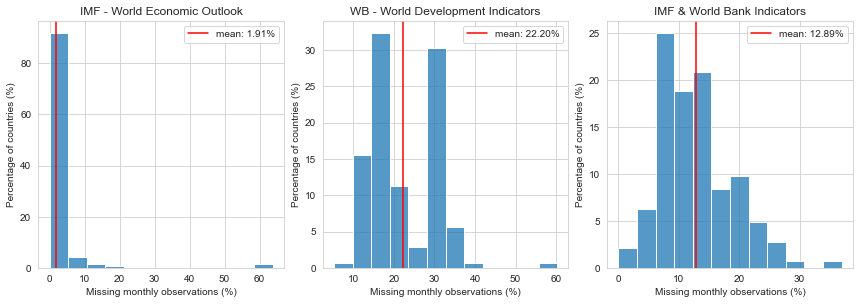

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.set_style("whitegrid")
plt.tight_layout()

sns.histplot(gid_nan_pct["NAN_PCT_IMF"], bins=12, stat="percent", ax=ax[0])
sns.histplot(gid_nan_pct["NAN_PCT_WB"], stat="percent", bins=12, ax=ax[1])
sns.histplot(gid_nan_pct["NAN_PCT_TOTAL"], stat="percent", bins=12, ax=ax[2])

ax[0].axvline(x=gid_nan_pct["NAN_PCT_IMF"].mean(),
            color='red', label='mean: {0:.2f}%'.format(gid_nan_pct["NAN_PCT_IMF"].mean()))
ax[1].axvline(x=gid_nan_pct["NAN_PCT_WB"].mean(),
            color='red', label='mean: {0:.2f}%'.format(gid_nan_pct["NAN_PCT_WB"].mean()))
ax[2].axvline(x=gid_nan_pct["NAN_PCT_TOTAL"].mean(),
            color='red', label='mean: {0:.2f}%'.format(gid_nan_pct["NAN_PCT_TOTAL"].mean()))

ax[0].set_title("IMF - World Economic Outlook")
ax[1].set_title("WB - World Development Indicators")
ax[2].set_title("IMF & World Bank Indicators")

ax[0].set_xlabel("Missing monthly observations (%)")
ax[1].set_xlabel("Missing monthly observations (%)")
ax[2].set_xlabel("Missing monthly observations (%)")

ax[0].set_ylabel("Percentage of countries (%)")
ax[1].set_ylabel("Percentage of countries (%)")
ax[2].set_ylabel("Percentage of countries (%)")

ax[0].legend()
ax[1].legend()
ax[2].legend()

    
fig.savefig('../img/missing_data_total_hist.svg', bbox_inches="tight")

### IMF

In [12]:
np.mean(gid_nan_pct["NAN_PCT_IMF"])

1.9140783878809362

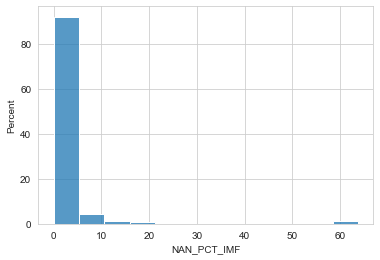

In [13]:
fig, ax = plt.subplots()

sns.histplot(gid_nan_pct["NAN_PCT_IMF"].dropna(), bins=12, stat="percent")

fig.savefig('../img/missing_data_imf_hist.svg',  bbox_inches="tight")

### WB

In [14]:
np.mean(gid_nan_pct["NAN_PCT_WB"])

22.19613249830589

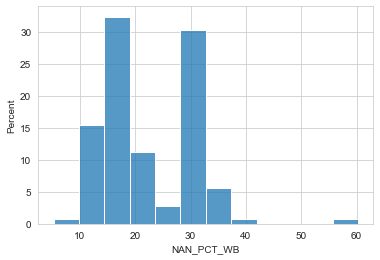

In [15]:
fig, ax = plt.subplots()

sns.histplot(gid_nan_pct["NAN_PCT_WB"], stat="percent", bins=12)

fig.savefig('../img/missing_data_wb_hist.svg', bbox_inches="tight")

In [16]:
###################################################################################################

In [17]:
percent_missing_total = list()
percent_missing_imf = list()
percent_missing_wb = list()

for i, g in enumerate(gid_list):
    print("######## "+g+" ("+str(i+1)+"/"+str(len(gid_list))+") #########")
    neighbor = gid0_neighbors[gid0_neighbors["GID_0"] == g]["NEIGHBOUR"].tolist()

    
    y, X = getData(target_variable = "SUM(FATALITIES)", 
                   target_country = g, 
                   predictor_countries = [],
                   socio_eco_vars = True,
                   n_lags_X = 1, 
                   seasonal_periodicity = 12)
    X_train, X_test, y_train, y_test = train_test_split(y=y, X=X, forecast_horizon=12)
    X_train = X_train.dropna(axis=1, how='all')
    percent_missing_total.append(X_train.isnull().sum().sum() / (X_train.shape[0] * X_train.shape[1]))
    
    # IMF
    imf_cols = [col for col in X_train.columns if col.startswith('IMF_')]
    X_train_imf = X_train[imf_cols]
    percent_missing_imf.append(X_train_imf.isnull().sum().sum() / (X_train_imf.shape[0] * X_train_imf.shape[1]))

    # WB
    wb_cols = [col for col in X_train.columns if col.startswith('WB_')]
    X_train_wb = X_train[wb_cols]
    percent_missing_wb.append(X_train_wb.isnull().sum().sum() / (X_train_wb.shape[0] * X_train_wb.shape[1]))


######## ABW (1/234) #########
Getting Data for ABW
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (38, 35)
y: (38, 1)
------------------------------------------------
######## AFG (2/234) #########
Getting Data for AFG
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (62, 55)
y: (62, 1)
------------------------------------------------
######## AGO (3/234) #########
Getting Data for AGO
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 60)
y: (301, 1)
------------------------------------------------
######## AIA (4/234) #########
Getting Data for AIA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (26, 0)
y: (26, 1)
------------------------------------------------
######## ALA (5/234) #########
Getting Data for ALA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (26, 0)
y: (26, 1)
--------------

IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 62)
y: (50, 1)
------------------------------------------------
######## CIV (42/234) #########
Getting Data for CIV
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 61)
y: (301, 1)
------------------------------------------------
######## CMR (43/234) #########
Getting Data for CMR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 61)
y: (301, 1)
------------------------------------------------
######## COD (44/234) #########
Getting Data for COD
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 61)
y: (301, 1)
------------------------------------------------
######## COG (45/234) #########
Getting Data for COG
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 60)
y: (301, 1)
------------------------------------------------
#####

IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 58)
y: (301, 1)
------------------------------------------------
######## GLP (82/234) #########
Getting Data for GLP
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 0)
y: (50, 1)
------------------------------------------------
######## GMB (83/234) #########
Getting Data for GMB
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 61)
y: (301, 1)
------------------------------------------------
######## GNB (84/234) #########
Getting Data for GNB
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 59)
y: (301, 1)
------------------------------------------------
######## GNQ (85/234) #########
Getting Data for GNQ
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 53)
y: (301, 1)
------------------------------------------------
######

IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 50)
y: (301, 1)
------------------------------------------------
######## LCA (122/234) #########
Getting Data for LCA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 54)
y: (50, 1)
------------------------------------------------
######## LIE (123/234) #########
Getting Data for LIE
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (26, 19)
y: (26, 1)
------------------------------------------------
######## LKA (124/234) #########
Getting Data for LKA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (146, 62)
y: (146, 1)
------------------------------------------------
######## LSO (125/234) #########
Getting Data for LSO
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 61)
y: (301, 1)
------------------------------------------------
###

IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (146, 64)
y: (146, 1)
------------------------------------------------
######## PAN (162/234) #########
Getting Data for PAN
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 63)
y: (50, 1)
------------------------------------------------
######## PER (163/234) #########
Getting Data for PER
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 65)
y: (50, 1)
------------------------------------------------
######## PHL (164/234) #########
Getting Data for PHL
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (74, 64)
y: (74, 1)
------------------------------------------------
######## PNG (165/234) #########
Getting Data for PNG
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (14, 58)
y: (14, 1)
------------------------------------------------
#######

IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 59)
y: (301, 1)
------------------------------------------------
######## TGO (202/234) #########
Getting Data for TGO
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (301, 61)
y: (301, 1)
------------------------------------------------
######## THA (203/234) #########
Getting Data for THA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (146, 63)
y: (146, 1)
------------------------------------------------
######## TJK (204/234) #########
Getting Data for TJK
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 62)
y: (50, 1)
------------------------------------------------
######## TKM (205/234) #########
Getting Data for TKM
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (50, 50)
y: (50, 1)
------------------------------------------------
###

In [18]:
gid_nan_pct = pd.DataFrame()
gid_nan_pct["GID_0"] = gid_list
gid_nan_pct["NAN_PCT_TOTAL"] = percent_missing_total
gid_nan_pct["NAN_PCT_IMF"] = percent_missing_imf
gid_nan_pct["NAN_PCT_WB"] = percent_missing_wb
gid_nan_pct["NAN_PCT_TOTAL"] = gid_nan_pct["NAN_PCT_TOTAL"] * 100
gid_nan_pct["NAN_PCT_IMF"] = gid_nan_pct["NAN_PCT_IMF"] * 100
gid_nan_pct["NAN_PCT_WB"] = gid_nan_pct["NAN_PCT_WB"] * 100

gid_nan_pct = gid_nan_pct[gid_nan_pct["GID_0"].isin(COI2)]
gid_nan_pct

,GID_0,NAN_PCT_TOTAL,NAN_PCT_IMF,NAN_PCT_WB
0,ABW,5.594406,0.000000,12.307692
1,AFG,11.698113,4.000000,15.027027
2,AGO,23.414072,2.137187,31.825863
5,ALB,10.615522,0.000000,15.275995
7,ARE,17.283019,0.000000,24.756757
...,...,...,...,...
221,VNM,13.159204,0.000000,18.361680
230,YEM,15.910250,0.000000,23.423423
231,ZAF,20.517950,3.824440,27.566321
232,ZMB,22.854965,6.411561,29.510628


### Total

In [19]:
np.mean(gid_nan_pct["NAN_PCT_TOTAL"])

16.304051975244658

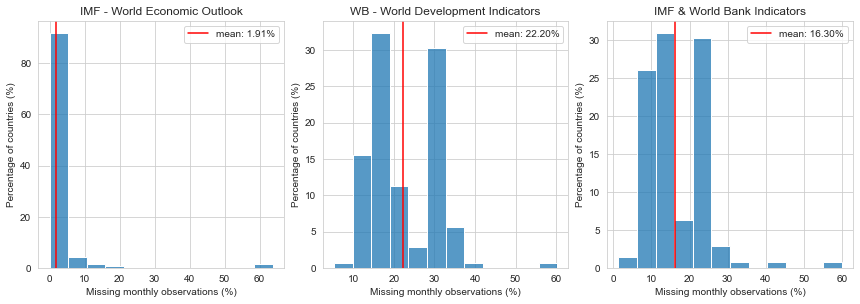

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.set_style("whitegrid")
plt.tight_layout()

sns.histplot(gid_nan_pct["NAN_PCT_IMF"], bins=12, stat="percent", ax=ax[0])
sns.histplot(gid_nan_pct["NAN_PCT_WB"], stat="percent", bins=12, ax=ax[1])
sns.histplot(gid_nan_pct["NAN_PCT_TOTAL"], stat="percent", bins=12, ax=ax[2])

ax[0].axvline(x=gid_nan_pct["NAN_PCT_IMF"].mean(),
            color='red', label='mean: {0:.2f}%'.format(gid_nan_pct["NAN_PCT_IMF"].mean()))
ax[1].axvline(x=gid_nan_pct["NAN_PCT_WB"].mean(),
            color='red', label='mean: {0:.2f}%'.format(gid_nan_pct["NAN_PCT_WB"].mean()))
ax[2].axvline(x=gid_nan_pct["NAN_PCT_TOTAL"].mean(),
            color='red', label='mean: {0:.2f}%'.format(gid_nan_pct["NAN_PCT_TOTAL"].mean()))

ax[0].set_title("IMF - World Economic Outlook")
ax[1].set_title("WB - World Development Indicators")
ax[2].set_title("IMF & World Bank Indicators")

ax[0].set_xlabel("Missing monthly observations (%)")
ax[1].set_xlabel("Missing monthly observations (%)")
ax[2].set_xlabel("Missing monthly observations (%)")

ax[0].set_ylabel("Percentage of countries (%)")
ax[1].set_ylabel("Percentage of countries (%)")
ax[2].set_ylabel("Percentage of countries (%)")

ax[0].legend()
ax[1].legend()
ax[2].legend()

    
# fig.savefig('../img/missing_data_total_hist.svg', bbox_inches="tight")

### IMF

In [21]:
np.mean(gid_nan_pct["NAN_PCT_IMF"])

1.9140783878809362

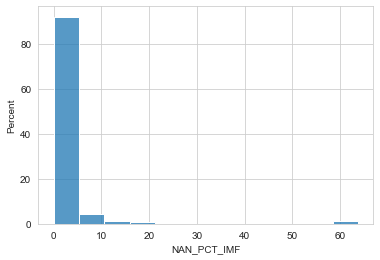

In [22]:
fig, ax = plt.subplots()

sns.histplot(gid_nan_pct["NAN_PCT_IMF"].dropna(), bins=12, stat="percent")

fig.savefig('../img/missing_data_imf_hist.svg',  bbox_inches="tight")

### WB

In [23]:
np.mean(gid_nan_pct["NAN_PCT_WB"])

22.19613249830589

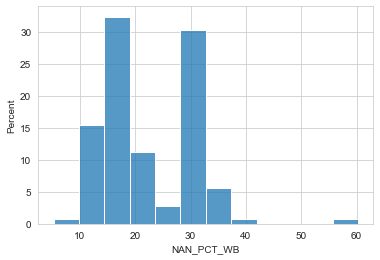

In [24]:
fig, ax = plt.subplots()

sns.histplot(gid_nan_pct["NAN_PCT_WB"], stat="percent", bins=12)

fig.savefig('../img/missing_data_wb_hist.svg', bbox_inches="tight")

In [25]:
acled_monthly_adm0 = pd.read_csv("../../data/TB003_EVENT_OUTCOMES_MONTHLY_START_DATE.csv")
gid0_neighbors = pd.read_csv("../../data/GID_0_Neighbours.csv")
# gid_list = acled_monthly_adm0["GID_0"].unique()[::-1] #reverse
gid_list = acled_monthly_adm0["GID_0"].unique()
len(gid_list)

neighbor = gid0_neighbors[gid0_neighbors["GID_0"] == "MLI"]["NEIGHBOUR"].tolist()
neighbor

FileNotFoundError: [Errno 2] No such file or directory: '../../data/TB003_EVENT_OUTCOMES_MONTHLY_START_DATE.csv'

In [ ]:
y, X = getData(target_variable="SUM(FATALITIES)", target_country="MLI", predictor_countries=neighbor, n_lags_X = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(y=y, X=X, forecast_horizon=12)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
# msno.heatmap(X_train)

In [ ]:
msno.matrix(X_train)

In [ ]:
msno.matrix(X_test)

In [ ]:
X_test.shape, X_train.shape

### MICE-Imputation with Linear Regression

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LinearRegression

mice = IterativeImputer(estimator= LinearRegression(), n_nearest_features=5, random_state=0)
X_train_preprocessed = mice.fit_transform(X_train)

X_test_preprocessed = mice.transform(X_test)


In [ ]:
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_train.columns, index=X_train.index)
X_train_preprocessed

In [ ]:
msno.matrix(X_train_preprocessed)

In [ ]:
X_train_preprocessed.describe().T

In [ ]:
X_train["WB_TOTAL_NATURAL_RESOURCES_MLI_T-1"].hist()

In [ ]:
for c in X_train.columns[20:]:
    print("------------- "+c+ "----------------------------------------")
    fig, ax = plt.subplots(2, 2)
    ax[0, 0].plot(X_train.index.to_timestamp(), X_train[c].values, color="blue")
    ax[0, 1].plot(X_train.index.to_timestamp(), X_train_preprocessed[c].values, color="red")
    
    ax[1, 0].hist(X_train_preprocessed[c], color="red")
    ax[1, 1].hist(X_train[c], color="blue")

    plt.show()

### Linear Interpolation

In [ ]:
X_train_preprocessed = X_train.interpolate(method="linear", axis=0, limit_direction="both")

In [ ]:
msno.matrix(X_train_preprocessed)

In [ ]:
for c in X_train.columns[20:]:
    print("------------- "+c+ "----------------------------------------")
    fig, ax = plt.subplots(2, 2)
    ax[0, 0].plot(X_train.index.to_timestamp(), X_train[c].values, color="blue")
    ax[0, 1].plot(X_train.index.to_timestamp(), X_train_preprocessed[c].values, color="red")
    
    ax[1, 0].hist(X_train_preprocessed[c], color="red")
    ax[1, 1].hist(X_train[c], color="blue")

    plt.show()